# Topological analyses Set 1

In [1]:
import os

import itertools
from collections import defaultdict


import networkx as nx

##### PyBEL imports

In [2]:
import pybel

from pybel.struct import get_subgraph_by_annotation_value
from pybel.struct.summary import count_functions

pybel.get_version()

'0.13.2'

##### PathMe import 

In [3]:
from pathme.constants import REACTOME_BEL
from pathme.export_utils import to_gml

##### DiffuPath import 

In [4]:

from diffupath.constants import DEFAULT_DIFFUPY_DIR
from diffupath.validation_datasets_parsers import parse_set1

from diffupath.pathme_processing import get_labels_by_db_and_omic_from_pathme, get_labels_by_db_and_omic_from_graph
from diffupath.input_mapping import get_mapping, get_mapping_subsets, get_mapping_two_dim_subsets
from diffupath.utils import print_dict_dimensions, get_labels_set_from_dict, reduce_dict_dimension, get_count_and_labels_from_two_dim_dict, from_pickle, to_pickle, get_three_venn_intersections, random_disjoint_intersection_three_subsets, get_count_and_labels_from_two_dim_dict
from diffupath.views import show_heatmap


## 1. Load Data Set 1: Input Scores

In [5]:
dataset1_labels_by_omics = parse_set1(os.path.join(DEFAULT_DIFFUPY_DIR, 'validation_datasets', 'set1.xlsx'))
dataset1_all_labels = get_labels_set_from_dict(dataset1_labels_by_omics)
print_dict_dimensions(dataset1_labels_by_omics, 'Dataset1 imported labels:')

Total number of genes: 4941  
Total number of micrornas: 100  
Total number of metabolite: 21  
Total: 5062 


In [6]:
mirnas_dataset =  dataset1_labels_by_omics['micrornas']

## 2. Load Backrgound Network and Kernel matrix

### 2.1. Import PathMeUniverse network graph

In [7]:
pathme_universe_graph_no_flatten = pybel.from_pickle(os.path.join(DEFAULT_DIFFUPY_DIR, 'pickles', 'universe', 'pathme_universe_bel_graph_no_flatten.bel.pickle'))
pathme_universe_graph_no_flatten.summarize()
count_functions(pathme_universe_graph_no_flatten)


PathMe Universe v1.0.0
Number of Nodes: 48643
Number of Edges: 104713
Number of Citations: 7696
Number of Authors: 0
Network Density: 4.43E-05
Number of Components: 6860
Number of Warnings: 0


Counter({'Composite': 1605,
         'Abundance': 7046,
         'BiologicalProcess': 2857,
         'Complex': 9048,
         'Reaction': 13576,
         'Gene': 14511})

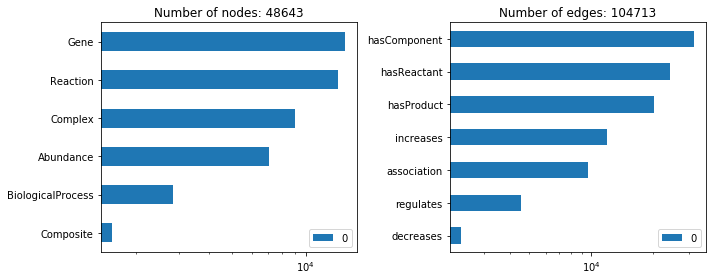

In [8]:
import matplotlib.pyplot as plt
from pybel_tools.summary import plot_summary, count_top_centrality
plot_summary(pathme_universe_graph_no_flatten, plt, figsize=(10, 4))
plt.show()

##### Check and filter isolates / Unconnected nodes

In [9]:
nx.number_of_isolates(pathme_universe_graph_no_flatten)

6426

In [10]:
pathme_universe_graph_no_flatten.remove_nodes_from({
    node
    for node in nx.isolates(pathme_universe_graph_no_flatten)
})

### 2.2. Get KEGG subgraph from PathMeUniverse graph

In [37]:
kegg_pathme_graph_no_flatten = get_subgraph_by_annotation_value(pathme_universe_graph_no_flatten, 'database', 'kegg')
kegg_pathme_graph_no_flatten.summarize()
count_functions(kegg_pathme_graph_no_flatten)

None vNone
Number of Nodes: 13162
Number of Edges: 35122
Number of Citations: 2
Number of Authors: 0
Network Density: 2.03E-04
Number of Components: 65
Number of Warnings: 0


Counter({'Composite': 1596,
         'Complex': 406,
         'Gene': 6149,
         'Abundance': 1762,
         'Reaction': 3137,
         'BiologicalProcess': 112})

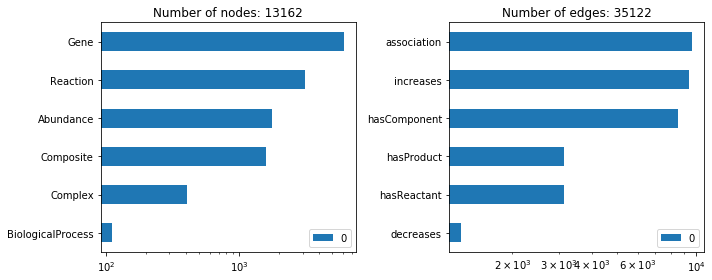

In [12]:
import matplotlib.pyplot as plt
from pybel_tools.summary import plot_summary, count_top_centrality
plot_summary(kegg_pathme_graph_no_flatten, plt, figsize=(10, 4))
plt.show()

### 2.3. Get entity labels subsets by entity type (omic) and by database

#####  2.3.2.  From PathMeUniverse KEGG subgraph

In [38]:
bg_labels_from_pathmeuniverse_by_db_and_omic, bg_labels_from_pathmeuniverse_by_omic_and_db =  get_labels_by_db_and_omic_from_graph(pathme_universe_graph_no_flatten)

print_dict_dimensions(bg_labels_from_pathmeuniverse_by_db_and_omic, 'Entities in PathMeUniverse :')

Total number of kegg: gene_nodes(6027), mirna_nodes(122), metabolite_nodes(1762), bp_nodes(112),  
Total number of reactome: gene_nodes(8615), mirna_nodes(13), metabolite_nodes(2684), bp_nodes(5),  
Total number of wikipathways: gene_nodes(2549), mirna_nodes(91), metabolite_nodes(618), bp_nodes(152),  
Total: 22750 


In [41]:
bg_labels_from_pathmeuniverse_by_omic = reduce_dict_dimension(bg_labels_from_pathmeuniverse_by_omic_and_db)

### 2.4. Get Background  Matrix Kernel

In [42]:
kernel_path = os.path.join(DEFAULT_DIFFUPY_DIR, 'kernels', 'kernel_regularized_pathme_universe.pickle')


##### Generate kernel OR load from pickle

DiffuPy to generate laplacian_kernel

In [16]:
#import diffupy
#from diffupy.kernels import regularised_laplacian_kernel

In [17]:
#background_mat = regularised_laplacian_kernel(kegg_pathme_graph_no_flatten)
#to_pickle(regularised_laplacian_kernel, kernel_path)

Import kernel from pickle

In [18]:
background_mat = from_pickle(kernel_path)

## 3. Dataset label mapping to PathMeEntities

##### All kernel matrix (background network) row labels for the mapping

In [19]:
background_labels = background_mat.rows_labels

### 3.1. General mapping

In [20]:
all_labels_mapping = get_mapping(dataset1_all_labels, background_labels, title = 'Global mapping: ', mirnas = mirnas_dataset, print_percentage = True)


Global mapping:  (2411) 47.62939549585144%


### 3.2. Mapping by subsets

#### 3.2.1. Mapping by entity type/omic

In [43]:
mapping_by_entity, _, _ = get_mapping_subsets(dataset1_labels_by_omics, background_labels, 'entity type/omic', mirnas = mirnas_dataset)


Mapping by entity type/omic:
genes (2393) 48.43149160089051%
micrornas (14) 14.000000000000002%
metabolite (18) 85.71428571428571%
bps (0) 0%
Total (2425) 47.90596602133544% 



In [44]:
micrornas_mapping = mapping_by_entity['micrornas'][0]

#### 3.2.2. Mapping by database

In [45]:
background_entites_by_db = {db : set(itertools.chain.from_iterable(entities.values())) for db, entities in bg_labels_from_pathmeuniverse_by_db_and_omic.items()}
mapping_by_db, _, _ = get_mapping_subsets(background_entites_by_db, dataset1_all_labels, 'database', mirnas = mirnas_dataset, submapping = background_labels, mirnas_mapping = micrornas_mapping, percentage_reference_labels = True)


Mapping by database:
kegg (1637) 32.33899644409324%
reactome (1272) 25.128407743974712%
wikipathways (805) 15.90280521532991%
Total (2419) 47.787435796128015% 



#### 3.2.3. Mapping by entity type and database (two dimentions)

In [46]:
mapping_by_database_and_entity, total_percentage, total_dimention = get_mapping_two_dim_subsets(bg_labels_from_pathmeuniverse_by_db_and_omic, dataset1_all_labels, relative_statistics = dataset1_labels_by_omics, mirnas_mapping = micrornas_mapping)


Mapping by Kegg:
gene_nodes (1615) 32.68569115563651%
mirna_nodes (11) 11.0%
metabolite_nodes (12) 57.14285714285714%
bp_nodes (0) 0%
Total (1638) 20.416303128505547% 

Mapping by Reactome:
gene_nodes (1259) 25.480671928759364%
mirna_nodes (1) 1.0%
metabolite_nodes (12) 57.14285714285714%
bp_nodes (0) 0%
Total (1272) 11.239727843067952% 

Mapping by Wikipathways:
gene_nodes (775) 15.68508399109492%
mirna_nodes (11) 11.0%
metabolite_nodes (18) 85.71428571428571%
bp_nodes (1) 0%
Total (805) 23.607038123167158% 

Total (2420) 47.80719083366258% 



### 3.3. Mapping descriptive view

TypeError: colorbar() argument after ** must be a mapping, not NoneType

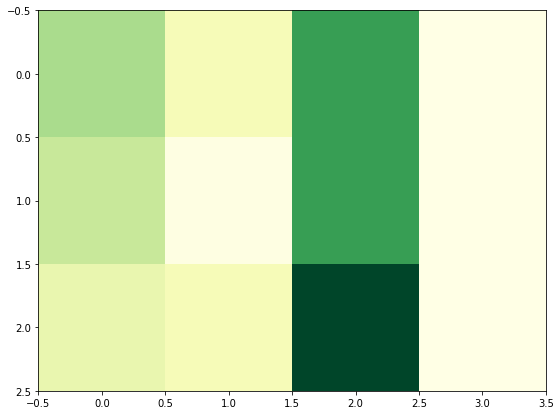

In [48]:
count, percentage, db_labels, entity_labels  = get_count_and_labels_from_two_dim_dict(mapping_by_database_and_entity)


show_heatmap(count, percentage, db_labels, entity_labels)

## 4. Resistance distance

In [9]:
from diffupath.topological_analyses import resistance_distance, filter_quadratic_mat_by_mapping
from diffupath.cross_validation import cross_validation_one_x_in

from diffupath.views import box_plot_from_two_dimension_dict
from diffupath.utils import get_mean_from_two_dim_dict

In [27]:
ER = resistance_distance(kegg_pathme_graph_no_flatten)

/Users/jmarinllao/Documents/Projectes/MultiPath/DiffuPy/src/diffupy/utils.py:20: UserWarning:

Since graph is directed, it will be converted to an undirected graph.



In [74]:
d_resistance_distance = filter_quadratic_mat_by_mapping(ER, mapping_by_entity)
d_resistance_distance_mean = get_mean_from_two_dim_dict(d_resistance_distance)

In [62]:
from diffupath.views import box_plot_from_dict, box_plot_from_two_dimension_dict

In [65]:
box_plot_from_two_dimension_dict(d_resistance_distance_mean, 'Resitance distance', 'Resitance distance')

In [40]:
box_plot_from_dict(d_resistance_distance_mean['genes'], 'Genes', 'Resitance distance')

/usr/local/Cellar/ipython/7.2.0/libexec/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [42]:
box_plot_from_dict(d_resistance_distance_mean['micrornas'], 'Micrornas', 'Resitance distance')

In [43]:
box_plot_from_dict(d_resistance_distance_mean['metabolite'], 'Metabolite', 'Resitance distance')

## 5. PageRank Centrality

In [10]:
from diffupath.topological_analyses import generate_pagerank_baseline
from statistics import mean

In [69]:
scores_page_rank = generate_pagerank_baseline(kegg_pathme_graph_no_flatten, background_mat)

In [94]:
d_page_rank = defaultdict(lambda: list())

for k1, v1 in mapping_by_entity.items():
    for e1 in v1[0]:
        d_page_rank[k1].append(scores_page_rank.get_cell_from_labels(e1, 'PageRank'))

In [95]:
d_page_rank_mean = {k1 : [mean(v1)] for k1, v1 in d_page_rank.items()}

In [97]:
box_plot_from_dict(d_page_rank_mean, 'Pagerank', 'Centrality study')

In [98]:
box_plot_from_dict(d_page_rank, 'Pagerank', 'Centrality study')